In [1]:
from scipy.spatial.distance import pdist, cdist, squareform
import numpy as np
from matplotlib import pyplot as plt
import copy
from scipy.optimize import minimize

In [2]:
class GP():
    def __init__(self, kernel, optimizer):
        self.kernel = kernel
        self.optimizer = optimizer
        
    def fit(self, X, y, eval_gradient=True):
        pass
    def predict(self, X):
        pass
    def sample_y(self, X, n_samples):
        pass
    def log_marginal_likelihood(self, theta=None, eval_gradient=None):
        pass

In [3]:
class RBF():
    
    def __init__(self, length_scale, signal_variance=1, noise_variance=1e-10):
        self.length_scale = length_scale
        self.signal_variance = signal_variance
        self.noise_variance = noise_variance
    
    def __call__(self, X1, X2=None, eval_gradient=False):
        if X2 is None:
            # Upper triangular pair-wise distances
            dists = pdist(X1, 'sqeuclidean')
            K_ = np.exp(-dists / (2 * self.length_scale ** 2))
            K_ = squareform(K_)  # copy upper-triangle to lower-triangle
            np.fill_diagonal(K_, 1)
        else:
            if eval_gradient:
                raise ValueError(
                    "Should only be evaluating gradient when X2 is None.")
            dists = cdist(X1, X2, metric='sqeuclidean')
            K_ = np.exp(-dists / (2 * self.length_scale ** 2))

        # Build total K
        K = self.signal_variance * K_
        if X2 is None:
            K[np.diag_indices_from(K)] += self.noise_variance
        
        if eval_gradient:
            K_grad = np.zeros((K.shape[0], K.shape[1], 3))
            # w.r.t length_scale
            K_grad[:, :, 0] = self.signal_variance * K_ * squareform(dists) / self.length_scale ** 3
            K_grad[:, :, 1] = K_  # w.r.t signal_variance
            K_grad[:, :, 2] = np.ones((K.shape))  # w.r.t noise_variance
            return K, K_grad
        else:
            return K
        
    def set_theta(self, length_scale, signal_variance, noise_variance):
        self.length_scale = length_scale
        self.signal_variance = signal_variance
        self.noise_variance = noise_variance
        
    def theta(self):
        return [self.length_scale, self.signal_variance, self.noise_variance]

In [4]:
def fit(self, X, y, eval_gradient=True):
    
    self.X_train_ = np.copy(X)
    self.y_train_ = np.copy(y)
    self.kernel_ = copy.copy(self.kernel)  # same as prior kernel but with parameters to be optimized
    
    # compute alpha of eqn. 2.25, needed for making predictions and computing lml
    K = self.kernel_(X, X)
    try:
        self.L_ = np.linalg.cholesky(K)
    except np.linalg.LinAlgError as e:
        e.args = ("The kernel, %s, is not returning a" 
                  "positive definite matrix. Try gradually "
                 "increasing the 'alpha' parameter of your "
                    "GaussianProcessRegressor estimator."
                  % self.kernel_,) + e.args
        raise
        
    self.alpha_ = np.linalg.solve(self.L_.T, np.linalg.solve(self.L_, y))
    
    def obj_func(theta, eval_gradient):
        if eval_gradient:
            lml, grad = self.log_marginal_likelihood(theta, eval_gradient=True)
            return -lml, -grad
        else:
            return -self.log_marginal_likelihood(theta)
            
    results = minimize(obj_func, self.kernel_.theta(), 
                                      args=(eval_gradient), method=self.optimizer, jac=eval_gradient)
    self.log_marginal_likelihood_value = results['fun']
    self.kernel_.set_theta(*results['x'])
    return self
GP.fit = fit

In [5]:
def predict(self, X):
    """ Returns predictive mean and variance."""
    if not hasattr(self, "X_train_"):  # Unfitted; predict based on GP prior.
        y_mean = np.zeros(X.shape[0])
        y_cov = self.kernel(X)
        return y_mean, y_cov
    else:  # Predict based on GP posterior using kernel with optimized params
        K_trans = self.kernel_(X, self.X_train_)
        y_mean = K_trans.dot(self.alpha_)  # Line 4 (y_mean = f_star)
        # y_mean = self._y_train_mean + y_mean  # undo normal.

        v = np.linalg.solve(self.L_, K_trans.T)  # self.L_.T * K_inv * K_trans.T
        y_cov = self.kernel_(X) - np.dot(v.T, v)  # Line 6
        return y_mean, y_cov
GP.predict = predict

In [6]:
def sample_y(self, X, n_samples=1):
    y_mean, y_cov = self.predict(X)
    try:
        L = np.linalg.cholesky(y_cov)
    except np.linalg.LinAlgError as e:
        e.args = ("The kernel, %s, is not returning a" 
                  "positive definite matrix. Try gradually "
                 "increasing the 'alpha' parameter of your "
                    "GaussianProcessRegressor estimator."
                  % self.kernel,) + e.args
        raise
    u = np.random.randn(X.shape[0], n_samples)
    z = np.dot(L, u) + y_mean[:, np.newaxis]
    return z
GP.sample_y = sample_y

In [7]:
def log_marginal_likelihood(self, theta=None, eval_gradient=False):
    
    if theta is None:
        assert hasattr(self, "log_marginal_likelihood_value")
        print('Using fitted theta')
        return self.log_marginal_likelihood_value
    
    kernel = copy.deepcopy(self.kernel)
    kernel.set_theta(*theta)
    
    if eval_gradient:
        K, K_gradient = kernel(self.X_train_, eval_gradient=True)
    else:
        K = kernel(self.X_train_)
       
    # Compute L and alpha for this K (theta)
    try:
        L = np.linalg.cholesky(K)
    except np.linalg.LinAlgError:
        return (-np.inf, np.zeros_like(theta)) if eval_gradient else -np.inf

    alpha = np.linalg.solve(L.T, np.linalg.solve(L, self.y_train_))
        
    # Compute log-likelihood (eqn. 2.30)
    log_likelihood = -0.5 * np.einsum("i,i", self.y_train_, alpha)
    log_likelihood -= np.log(np.diag(L)).sum()
    log_likelihood -= K.shape[0] / 2 * np.log(2 * np.pi)

    if eval_gradient:
        # Compute lml gradient w.r.t kernel params (eqn. 5.9)
        tmp = np.einsum("i,j->ij", alpha, alpha)
        tmp -= np.linalg.solve(L.T, np.linalg.solve(L, np.eye(K.shape[0])))  # K inverse
        log_likelihood_gradient = 0.5 * np.einsum("ij,ijk->k", tmp, K_gradient)  # note K_gradient symmetric so ij same as ji. l output dim and k num params
    
    if eval_gradient:
        return log_likelihood, log_likelihood_gradient
    else:
        return log_likelihood
GP.log_marginal_likelihood = log_marginal_likelihood

In [8]:
X = np.sort(np.random.uniform(-5, 5, 10))[:, np.newaxis]
kernel = RBF(1, 1, 1e-10)
gp = GP(kernel, 'L-BFGS-B')

In [9]:
# Sample from prior and take as observations
y_sample = gp.sample_y(X)

In [10]:
y_sample.shape

(10, 1)

In [11]:
%%capture
fig, ax = plt.subplots()

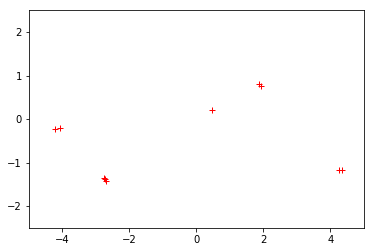

In [12]:
ax.plot(X, y_sample, 'r+')
ax.set_xlim(-5, 5)
ax.set_ylim(-2.5, 2.5)
fig

In [13]:
X_test = np.arange(-5, 5, 0.005)[:, np.newaxis]

In [14]:
gp.fit(X, y_sample[:, 0])

In [15]:
gp.kernel_.theta()

[1.0, 1.0, 1e-10]

In [16]:
gp.kernel.theta()

[1, 1, 1e-10]

In [17]:
y_pred_mean, y_pred_covar = gp.predict(X_test)

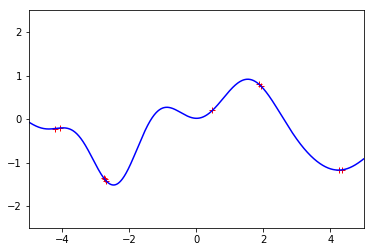

In [18]:
ax.plot(X_test, y_pred_mean, 'b')
fig

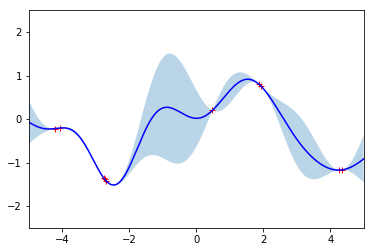

In [19]:
# compute 95% confidence interval from pointwise variances and plot
pointwise_variances = y_pred_covar.diagonal()
error = 1.96 * np.sqrt(pointwise_variances)
ax.fill_between(X_test[:, 0], y_pred_mean - error, y_pred_mean + error, alpha=0.3)
fig

In [20]:
y_pred_sample = gp.sample_y(X_test, n_samples=5)

In [21]:
y_pred_sample.shape

(2000, 5)

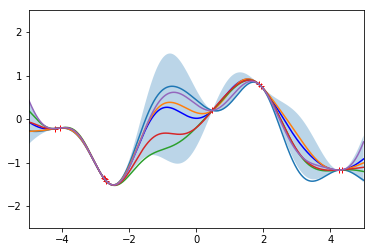

In [22]:
for i in range(y_pred_sample.shape[1]):
    ax.plot(X_test, y_pred_sample[:, i])
fig

In [23]:
gp.log_marginal_likelihood()

Using fitted theta


-3.5904537375745083

In [176]:
# Plot log marginal likelihood w.r.t. different values of theta
length_scales = np.linspace(0.95, 1.2, 100)
noise_variance = np.linspace(1e-11, 1e-4, 100)
X, Y = np.meshgrid(length_scales, noise_variance)

In [177]:
X.shape

(100, 100)

In [178]:
Z = np.array(list(map(lambda x: gp.log_marginal_likelihood(theta=[x[0], 1, x[1]]), list(zip(X.ravel(), Y.ravel())))))

In [179]:
Z = Z.reshape((X.shape))

In [180]:
Z.shape

(100, 100)

<a list of 9 text.Text objects>

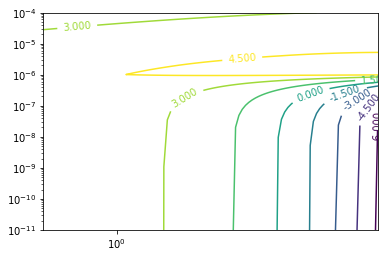

In [181]:
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_yscale('log')
CS = ax.contour(X, Y, Z)
plt.clabel(CS, inline=1, fontsize=10)

tmp